In [1]:
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.draw import disk
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Input, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
# Maximum number of cores we expect in any image
MAX_CORES = 256  # Adjust this number based on your dataset

def create_label_array(json_data):
    labels = []
    for item in json_data:
        labels.append([item['x'], item['y'], item['radius']])
    # If there are fewer cores than MAX_CORES, we pad the remaining values with 0
    while len(labels) < MAX_CORES:
        labels.append([0, 0, 0])  # Padding
    labels_flat = np.array(labels).flatten()
    # Normalize and flatten the labels to be between 0 and 1, except for padding values which remain 0
    for i in range(0, len(labels_flat), 3):
        if labels_flat[i] != 0:
            labels_flat[i] /= 1024
            labels_flat[i+1] /= 1024
            labels_flat[i+2] /= 1024
    return labels_flat

def load_images_and_labels(image_dir, label_dir):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]

    images = []
    labels = []

    for image_file, label_file in zip(image_files, label_files):
        # Load image
        image = img_to_array(load_img(image_file, color_mode='rgb'))
        images.append(image / 255.0)  # Normalize the image

        # Load corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        label = create_label_array(json_data)
        labels.append(label)

    return np.array(images), np.array(labels)


# Usage
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'
images, labels = load_images_and_labels(image_dir, label_dir)


In [5]:
labels[0]

array([0.67484799, 0.9584839 , 0.02050781, 0.63689222, 0.95836265,
       0.02050781, 0.51830787, 0.95696212, 0.02050781, 0.47422477,
       0.95246469, 0.02050781, 0.4461997 , 0.95300336, 0.02050781,
       0.40591982, 0.95212648, 0.02050781, 0.33213435, 0.95209927,
       0.02050781, 0.29367329, 0.94923416, 0.02050781, 0.17910226,
       0.94507225, 0.02050781, 0.2550067 , 0.94649648, 0.02050781,
       0.21700379, 0.94631954, 0.02050781, 0.14083668, 0.93906828,
       0.02050781, 0.48365068, 0.91360363, 0.02050781, 0.17984267,
       0.90260694, 0.02050781, 0.78911114, 0.88022895, 0.02050781,
       0.67867021, 0.88054992, 0.02050781, 0.64090349, 0.87714357,
       0.02050781, 0.25540466, 0.86533323, 0.02050781, 0.21561345,
       0.86383388, 0.02050781, 0.17871942, 0.85931477, 0.02050781,
       0.05869408, 0.85494121, 0.02050781, 0.86796468, 0.84733176,
       0.02050781, 0.82914161, 0.84566085, 0.02050781, 0.68129128,
       0.84158529, 0.02050781, 0.64167911, 0.833364  , 0.02050

In [3]:

def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_regression(input_size=(1024, 1024, 3), num_filters=64, depth=4, dropout=0.5, batch_norm=True, max_cores = 256):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)


    # OLD OUTPUT LAYER
    # output = Conv2D(1, 1, activation='sigmoid')(x)
    # model = Model(inputs=inputs, outputs=output)

    # NEW OUTPUT LAYER
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    # Adjust the number of outputs to be 3 * MAX_CORES
    outputs = Dense(3 * max_cores, activation='sigmoid')(x)  # 3 values for each core: x, y, and radius

    model = Model(inputs=inputs, outputs=outputs)

    return model




In [4]:

import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

# Assuming 'images' and 'labels' are loaded and preprocessed correctly

# Define a custom loss function that can handle the padding
def custom_loss(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # Create a mask for the padding
    loss = MeanSquaredError()(y_true * mask, y_pred * mask)  # Apply the mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Normalize by the number of non-padded entries

checkpoint_path = './model_checkpoint.h5'

# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading the model.")
    model = load_model(checkpoint_path, custom_objects={'custom_loss': custom_loss})
else:
    print("No checkpoint found. Starting training from scratch.")
    model = unet_regression(input_size=(1024, 1024, 3), num_filters=64, depth=4, dropout=0.5, batch_norm=True, max_cores=256)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss)

# Set up callbacks for learning rate scheduling and checkpointing
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, verbose=1, mode='min', min_lr=1e-8)

# Split your data into training and validation sets
# This is a simple split, consider using sklearn's train_test_split for a random split
# val_split = 0.1  # Use 10% of data for validation
# num_val_samples = int(val_split * len(images))
# train_images, val_images = images[:-num_val_samples], images[-num_val_samples:]
# train_labels, val_labels = labels[:-num_val_samples], labels[-num_val_samples:]

No checkpoint found. Starting training from scratch.


In [6]:

# # Train the model
# history = model.fit(
#     train_images, 
#     train_labels, 
#     validation_data=(val_images, val_labels),
#     epochs=5,  # Set the number of epochs
#     batch_size=3,  # Set the batch size
#     callbacks=[checkpoint, reduce_lr]
# )

# Train the model
history = model.fit(
    images, 
    labels, 
    epochs=5,  # Set the number of epochs
    batch_size=3,  # Set the batch size
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/5


In [15]:
import matplotlib.pyplot as plt
# Function to convert model output back to readable coordinates and radii
def convert_predictions(predictions, max_cores, image_size=1024):
    converted = []
    for i in range(0, len(predictions), 3):
        if predictions[i] != 0:  # Ignoring padding
            x = predictions[i] * image_size
            y = predictions[i+1] * image_size
            radius = predictions[i+2] * image_size
            converted.append((x, y, radius))
    return converted

# Function to overlay the predictions on the images
def overlay_predictions(images, predictions, max_cores, alpha=0.5):
    overlay_images = []
    core_counts = []  # To store the count of cores for each image
    core_details = []  # To store the details of cores for each image
    for image, prediction in zip(images, predictions):
        overlay_image = np.copy(image)
        count = 0
        details = []
        for i in range(0, len(prediction), 3):
            if prediction[i] != 0:  # Ignoring padding
                x = int(prediction[i] * image.shape[1])
                y = int(prediction[i+1] * image.shape[0])
                radius = prediction[i+2] * image.shape[1]  # Assuming width and height are the same
                rr, cc = disk((y, x), radius, shape=overlay_image.shape[:2])
                overlay_image[rr, cc, 0] = 255  # Red channel
                # Alpha blending
                overlay_image[rr, cc, 1:] = (1 - alpha) * overlay_image[rr, cc, 1:]  # Green and blue channels
                count += 1
                details.append((x, y, radius))
        overlay_images.append(overlay_image)
        core_counts.append(count)
        core_details.append(details)
    return overlay_images, core_counts, core_details


1/1 [==============================] - 12s 12s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


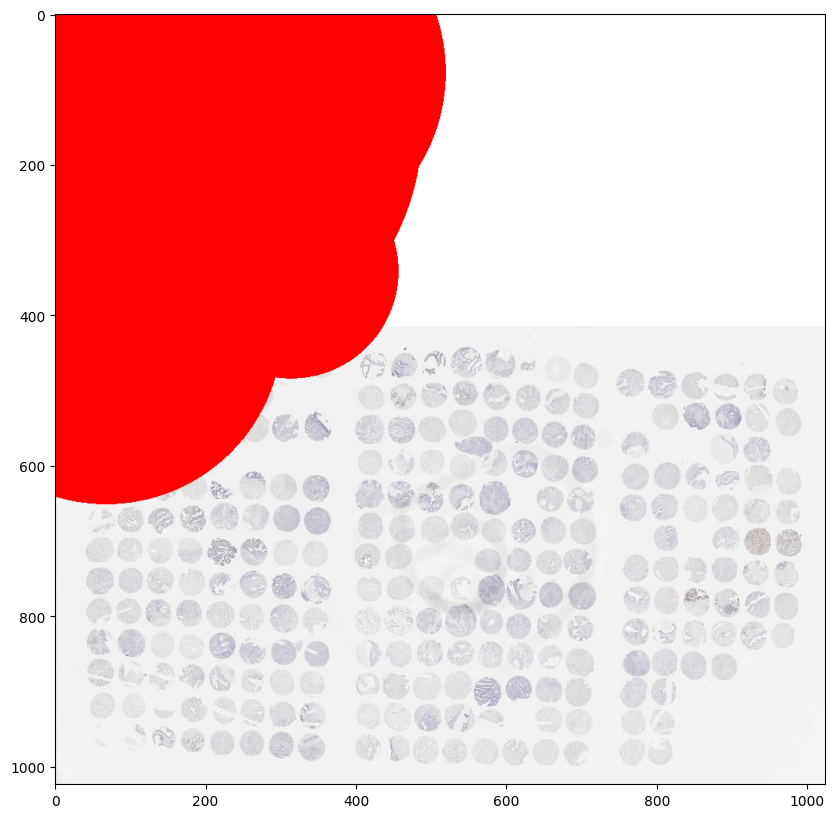

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


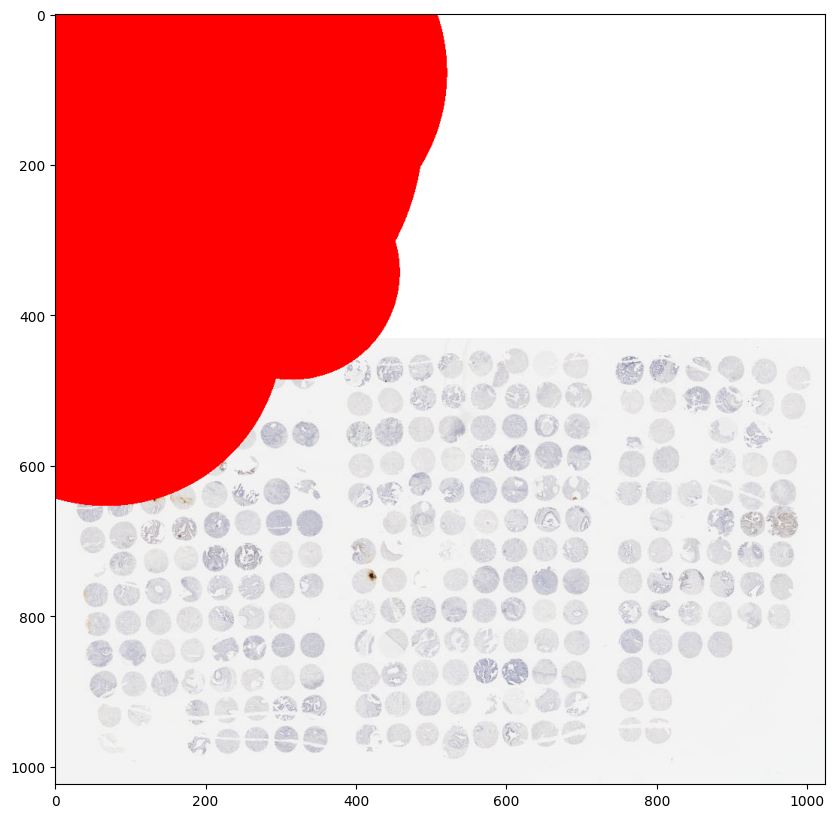

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


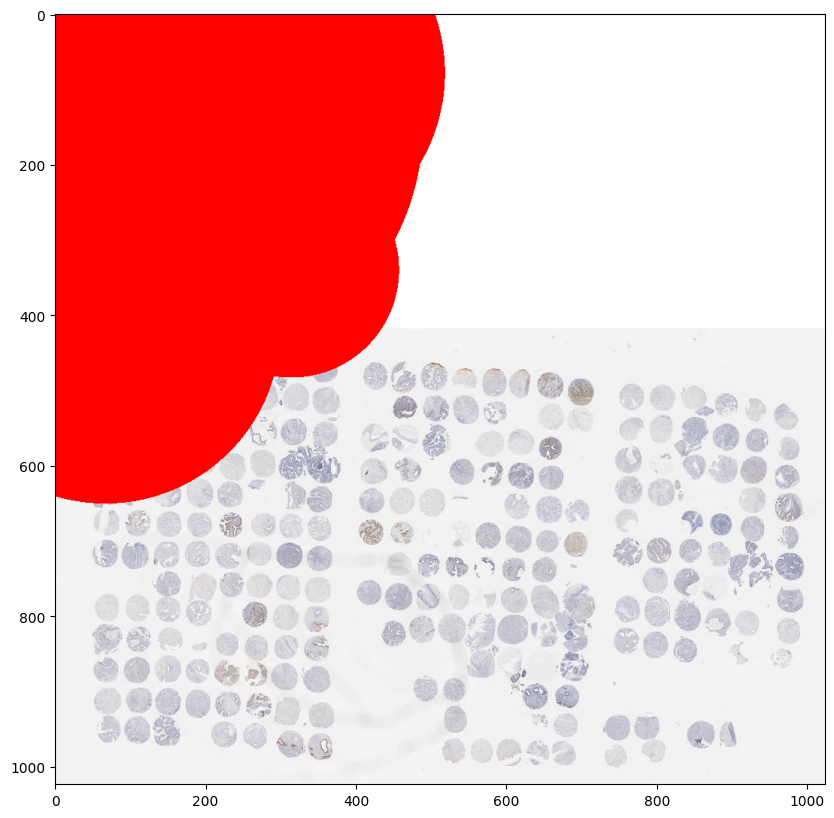

In [17]:
number_of_images = 3  # Number of images to visualize
# Predicting on validation images
predictions = model.predict(images[:number_of_images])

# Overlaying the predictions on the images
overlay_images, core_counts, core_details = overlay_predictions(images[:number_of_images], predictions, MAX_CORES, alpha=0.5)

# Visualizing the first few overlay images with core counts and radii
for i in range(number_of_images):  # Just showing first 3 images for example
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_images[i])
    plt.title(f'Number of predicted cores: {core_counts[i]}')
    for detail in core_details[i]:
        x, y, radius = detail
        plt.text(x, y, f'R: {radius:.2f}', color='yellow', fontsize=8)
    plt.show()

In [11]:
predictions[0]

array([ 1.00287803e-01,  2.64355890e-03, -5.01766428e-02, -6.80659190e-02,
        7.25442022e-02, -1.23788662e-01,  1.42223582e-01, -1.94311380e-01,
        2.95143742e-02,  8.53521526e-02,  1.89407036e-01, -1.59501657e-01,
       -2.71896031e-02, -1.41696900e-01,  1.95283249e-01,  2.97911853e-01,
        1.66953430e-01, -1.76665559e-01, -1.67750731e-01, -7.33002722e-02,
        3.28098357e-01, -5.04270159e-02,  1.75261170e-01,  9.42268819e-02,
        6.60717413e-02,  4.07303184e-01, -2.28837147e-01,  4.11640964e-02,
        4.89159785e-02, -8.80153999e-02,  8.17853659e-02, -2.67869961e-02,
       -1.44244626e-01, -2.13198811e-01,  5.20014055e-02, -7.81727061e-02,
       -1.05728596e-01, -6.68252632e-02,  3.60207111e-02,  9.54981744e-02,
        1.87585298e-02,  5.48457168e-02,  4.27978821e-02, -8.64091590e-02,
       -1.02825880e-01, -2.00784411e-02, -7.36255199e-02,  9.77788642e-02,
        2.81193733e-01,  7.14931544e-03, -4.19409648e-02,  3.58242542e-04,
        2.61067659e-01, -